In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

In [12]:
train = pd.read_csv("../../../1. Data Cleaning/Cleaned Datasets/Training_Set_grouped_binary.csv")
test = pd.read_csv("../../../1. Data Cleaning/Cleaned Datasets/Testing_Set_grouped_binary.csv")

X_train = train.drop(columns=['readmitted', 'Unnamed: 0'])
y_train = train['readmitted'].replace({'NO': 0, '>30': 1, '<30': 2})

X_test = test.drop(columns=['readmitted', 'Unnamed: 0'])
y_test = test['readmitted'].replace({'NO': 0, '>30': 1, '<30': 2})

### XGBoost - all features

In [30]:
def train_xgb(X_train, y_train):
    # Defining the hyperparameter grid
    param_grid_xgb = {
        'n_estimators': [50, 100, 200],
        'max_depth': [2, 3, 5],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    # Setting up the grid search with XGBoost
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=10)
    grid_search_xgb.fit(X_train, y_train)

    # Training the best XGBoost model
    best_xgb_model = grid_search_xgb.best_estimator_
    return best_xgb_model

best_xgb1 = train_xgb(X_train, y_train)

In [37]:
optimal_hyperparameters = best_xgb1.get_params()
print(optimal_hyperparameters)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


In [31]:
def evaluate_model(model, X_test, y_test, label, results):
    y_pred_xgb = model.predict(X_test)
    y_pred_proba_xgb = model.predict_proba(X_test)[:,1]
    
#     conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
    precision_xgb = precision_score(y_test, y_pred_xgb, pos_label=1)
    recall_xgb = recall_score(y_test, y_pred_xgb, pos_label=1)
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    f1_xgb = f1_score(y_test, y_pred_xgb, pos_label=1)
    auc_roc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_xgb).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
#     fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_xgb, pos_label=1)
#     auc_pr_xgb = metrics.auc(fpr, tpr)
    
    xgb_results = pd.DataFrame({
        label: [tp, fp,
                    tn, fn,
                    precision_xgb, recall_xgb, accuracy_xgb, f1_xgb, auc_roc_xgb,
               sensitivity, specificity]
    })

    results2 = pd.concat([results, xgb_results], axis=1)
    return results2

In [32]:
results = pd.DataFrame({
    'Metric': ['True Positives', 'False Positives', 'True Negatives', 'False Negatives', 
               'Precision', 'Recall', 'Accuracy', 'F1 Score', 'AUC-ROC',
               'Sensitivity', 'Specificity'],
})

results1 = evaluate_model(best_xgb1, X_train, y_train, "XGBoost - All Features - Train", results)
results2 = evaluate_model(best_xgb1, X_test, y_test, "XGBoost - All Features - Test", results1)
results2

,Metric,XGBoost - All Features - Train,XGBoost - All Features - Test
0,True Positives,19802.000000,4814.000000
1,False Positives,10849.000000,2783.000000
2,True Negatives,31099.000000,7793.000000
3,False Negatives,17817.000000,4383.000000
4,Precision,0.646047,0.633671
5,Recall,0.526383,0.523432
6,Accuracy,0.639725,0.637587
7,F1 Score,0.580108,0.573300
8,AUC-ROC,0.694533,0.683689
9,Sensitivity,0.526383,0.523432


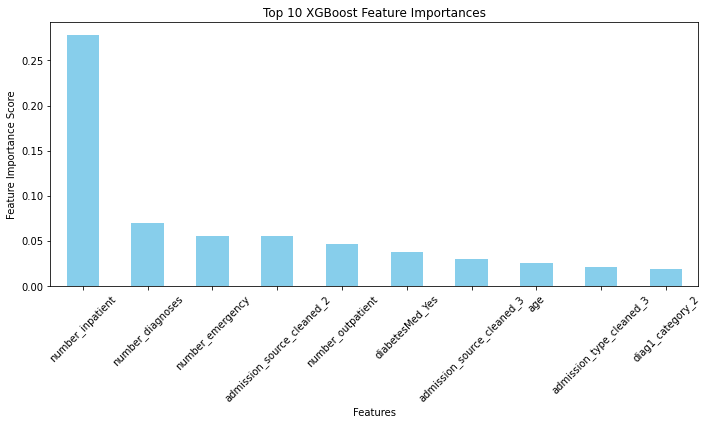

In [38]:
importances_xgb = best_xgb1.feature_importances_
xgb_importances = pd.Series(importances_xgb, index=X_train.columns)

# Sort the features by importance in descending order
xgb_importances_sorted = xgb_importances.sort_values(ascending=False)

# Select only the top 20 important features
top_10_xgb_features = xgb_importances_sorted.head(10)

# Plot the top 20 feature importances for XGBoost
fig, ax = plt.subplots(figsize=(10, 6))
top_10_xgb_features.plot.bar(ax=ax, color='skyblue')
ax.set_title("Top 10 XGBoost Feature Importances")
ax.set_ylabel("Feature Importance Score")
ax.set_xlabel("Features")
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()

plt.show()

### XGBoost - boruta features

In [34]:
sub_features = [
    "age", "time_in_hospital", "num_lab_procedures", "num_procedures", 
    "num_medications", "number_outpatient", "number_emergency", "number_inpatient", 
    "number_diagnoses", "med_count_1", "med_count_2", "med_count_3", 
    "med_count_4", "med_count_6", "race_Caucasian", "race_Hispanic", 
    "race_Other", "race_Unknown", "gender_Male", "A1Cresult_>8", 
    "A1Cresult_Norm", "A1Cresult_Not Taken", "diabetesMed_Yes", 
    "med_change_1_NoMed", "med_change_1_Steady", "med_change_1_Up", 
    "med_change_2_NoMed", "med_change_2_Steady", "med_change_2_Up", 
    "med_change_3_NoMed", "med_change_3_Steady", "med_change_4_NoMed", 
    "med_change_4_Steady", "med_change_6_NoMed", "med_change_6_Steady", 
    "med_change_6_Up", "med_change_other_Yes", "discharge_group_2", 
    "discharge_group_3", "discharge_group_4", "discharge_group_7", 
    "admission_type_cleaned_1", "admission_type_cleaned_2", 
    "admission_type_cleaned_3", "admission_source_cleaned_1", 
    "admission_source_cleaned_2", "admission_source_cleaned_3", 
    "diag1_category_1", "diag1_category_2", "diag1_category_3", 
    "diag1_category_4", "diag1_category_5", "diag1_category_6", 
    "diag1_category_7", "diag1_category_8", "diag1_category_9", 
    "max_glu_serum_cleaned_>300", "max_glu_serum_cleaned_Norm", 
    "max_glu_serum_cleaned_Not Taken"
]

X_train_boruta = X_train[sub_features]
X_test_boruta = X_test[sub_features]

In [35]:
best_xgb2 = train_xgb(X_train_boruta, y_train)

In [36]:
results3 = evaluate_model(best_xgb2, X_train_boruta, y_train, "XGBoost - Boruta Features - Train", results2)
results4 = evaluate_model(best_xgb2, X_test_boruta, y_test, "XGBoost - Boruta Features - Test", results3)
results4

,Metric,XGBoost - All Features - Train,XGBoost - All Features - Test,XGBoost - Boruta Features - Train,XGBoost - Boruta Features - Test
0,True Positives,19802.000000,4814.000000,19959.000000,4834.000000
1,False Positives,10849.000000,2783.000000,10925.000000,2806.000000
2,True Negatives,31099.000000,7793.000000,31023.000000,7770.000000
3,False Negatives,17817.000000,4383.000000,17660.000000,4363.000000
4,Precision,0.646047,0.633671,0.646257,0.632723
5,Recall,0.526383,0.523432,0.530556,0.525606
6,Accuracy,0.639725,0.637587,0.640743,0.637435
7,F1 Score,0.580108,0.573300,0.582719,0.574212
8,AUC-ROC,0.694533,0.683689,0.694245,0.683083
9,Sensitivity,0.526383,0.523432,0.530556,0.525606


### XGBoost - categorical target

In [72]:
def train_xgb(X_train, y_train, num_class):
    # Defining the hyperparameter grid
    param_grid_xgb = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 15],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    # Setting up the grid search with XGBoost
    xgb = XGBClassifier(num_class = num_class, use_label_encoder=False, eval_metric='logloss')
    grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5)
    grid_search_xgb.fit(X_train, y_train)

    # Training the best XGBoost model
    best_xgb_model = grid_search_xgb.best_estimator_
    return best_xgb_model

best_xgb2 = train_xgb(X_train, y_train, 3)

In [53]:
best_xgb2.predict(X_test)

array([2, 2, 2, ..., 2, 0, 2])

In [46]:
from sklearn.multiclass import OneVsRestClassifier

ovr_classifier = OneVsRestClassifier(best_xgb2)
ovr_classifier.fit(X_train, y_train)

# Predictions and evaluation on the test set
y_pred_ovr_xgb = ovr_classifier.predict(X_test)
y_pred_proba_ovr_xgb = ovr_classifier.predict_proba(X_test)

XGBoostError: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.

In [33]:
def get_scores(y_test, y_pred_xgb, y_pred_proba_xgb_pred, results, label):
#     y_pred_xgb = best_xgb_model.predict(X_test)
#     y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:,1]
    conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
    precision_xgb = precision_score(y_test, y_pred_xgb, pos_label=1)
    recall_xgb = recall_score(y_test, y_pred_xgb, pos_label=1)
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    f1_xgb = f1_score(y_test, y_pred_xgb, pos_label=1)
    auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

    xgb_results = pd.DataFrame({
        label: [conf_matrix_xgb[1][1], conf_matrix_xgb[0][1],
                    conf_matrix_xgb[0][0], conf_matrix_xgb[1][0],
                    precision_xgb, recall_xgb, accuracy_xgb, f1_xgb, auc_xgb]
    })

    results = pd.concat([results, xgb_results], axis=1)
    return results

SyntaxError: invalid character '，' (U+FF0C) (<ipython-input-33-8986aa12e404>, line 1)